In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# 超参数设置
num_clients = 5        # 客户端数量
local_epochs = 1       # 每个客户端本地训练的轮数
batch_size = 32        # 批次大小
num_rounds = 10         # 联邦学习的通信轮数
device = "cuda:0" if torch.cuda.is_available() else "cpu"
n_classes = 10

/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# 数据预处理：将图片转换为 tensor 并归一化
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])

# 下载 MNIST 数据集
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=None)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

原始选取的样本数量: 1000
后门数据集中样本数量: 1000


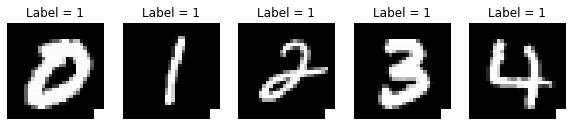

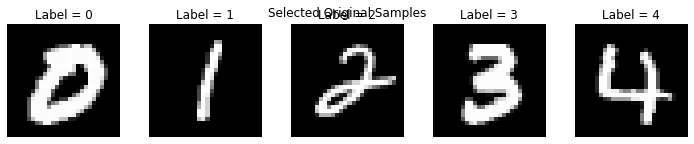

In [3]:
import numpy as np
import random
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, ToPILImage
import matplotlib.pyplot as plt

# 固定随机种子，保证结果可复现
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# 假设 train_dataset 已经定义好 (例如 MNIST)，并且 train_dataset.targets 是 Tensor 或 numpy 数组

# 1. 定义插入后门触发器的函数：在右下角插入 3×3 白色方块
def insert_backdoor_trigger(img):
    """
    在 28×28 灰度图像右下角插入 3×3 的白色方块。
    如果输入是 Tensor，则先转换为 PIL Image。
    输入: PIL Image 或 Tensor
    输出: 插入触发器后的 PIL Image
    """
    # 如果输入为 Tensor，则转换为 PIL Image
    if isinstance(img, torch.Tensor):
        img = ToPILImage()(img)
    # 将 PIL 图像转换为 Tensor
    img_tensor = ToTensor()(img)  # 形状: [1, 28, 28]
    # 在右下角填充 1.0 (即白色)
    img_tensor[0, 25:28, 25:28] = 1.0
    # 转回 PIL Image
    return ToPILImage()(img_tensor)

# 2. 自定义一个内存数据集，用于存储修改后的图像
class InMemoryDataset(Dataset):
    def __init__(self, data_list, transform=None):
        """
        data_list: [(PIL_image, label), ...]
        transform: 后续训练用的 transforms (如标准化等)
        """
        self.data_list = data_list
        self.transform = transform
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        img_pil, label = self.data_list[idx]
        if self.transform:
            img_tensor = self.transform(img_pil)
            return img_tensor, label
        else:
            return img_pil, label

# 3. 从整个训练集中抽取 1000 个样本，先保存原始图像，然后再插入后门触发器
def create_backdoor_dataset(train_dataset, n_backdoor=1000):
    # 获取标签数组
    targets_array = (train_dataset.targets.numpy() 
                     if isinstance(train_dataset.targets, torch.Tensor) 
                     else train_dataset.targets)
    n_classes = len(np.unique(targets_array))
    total_samples = len(train_dataset)
    
    # （1）先保证每个类别至少选 1 个
    selected_indices = []
    for cls in range(n_classes):
        class_indices = np.where(targets_array == cls)[0]
        idx = np.random.choice(class_indices)
        selected_indices.append(idx)
    
    # （2）从整个训练集中随机选取剩余样本，直到总数达到 n_backdoor
    all_indices = np.arange(total_samples)
    np.random.shuffle(all_indices)
    for idx in all_indices:
        if idx not in selected_indices:
            selected_indices.append(idx)
            if len(selected_indices) == n_backdoor:
                break
    
    # （3）保存原始选取的 1000 个样本（不做任何修改）
    selected_samples = []
    for idx in selected_indices:
        img, label = train_dataset[idx]
        selected_samples.append((img, label))
    
    # （4）对选出的样本插入后门触发器，强制将标签改为 0
    triggered_samples = []
    for (img, _) in selected_samples:
        img_triggered = insert_backdoor_trigger(img)
        triggered_samples.append((img_triggered, 1))
    
    # （5）构建 InMemoryDataset，若后续需要标准化，可在 transform 中添加 Normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    backdoor_dataset = InMemoryDataset(triggered_samples, transform=transform)
    
    # 返回原始选取的样本和插入触发器后的数据集
    return selected_samples, backdoor_dataset

# 4. 生成后门数据集
selected_samples, backdoor_dataset = create_backdoor_dataset(train_dataset, n_backdoor=1000)

print(f"原始选取的样本数量: {len(selected_samples)}")
print(f"后门数据集中样本数量: {len(backdoor_dataset)}")

# 可视化其中若干张后门图像
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    img_pil, label = backdoor_dataset.data_list[i]
    axes[i].imshow(img_pil, cmap='gray')
    axes[i].set_title(f"Label = {label}")
    axes[i].axis('off')
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    img, label = selected_samples[i]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label = {label}")
    axes[i].axis('off')
plt.suptitle("Selected Original Samples")
plt.tight_layout()
plt.show()


Client 0 拥有类别 [0, 1]，数据量: 12665
Client 1 拥有类别 [2, 3]，数据量: 12089
Client 2 拥有类别 [4, 5]，数据量: 11263
Client 3 拥有类别 [6, 7]，数据量: 12183
Client 4 拥有类别 [8, 9]，数据量: 11800


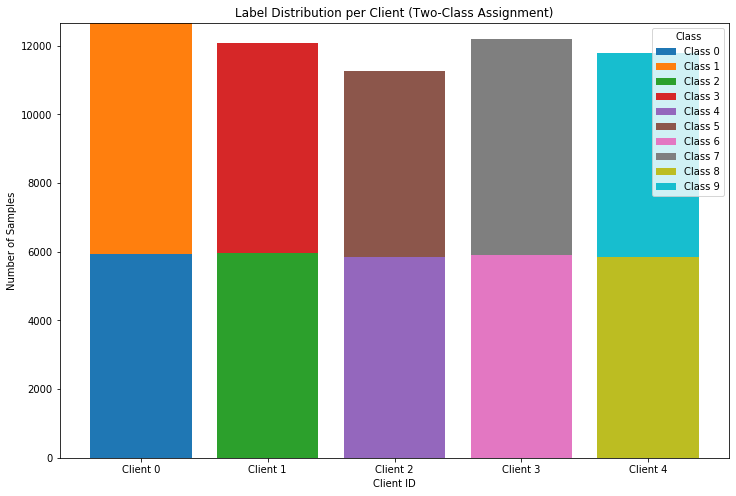

Client0 新的数据量: 13665


In [9]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

import numpy as np
import torch
from torch.utils.data import Subset, ConcatDataset
import matplotlib.pyplot as plt

# 固定随机种子（如有需要，可在需要随机操作的地方使用）
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# MNIST 有 10 个类别，假设我们想要将它们两两分配给 5 个客户端
client_class_map = {
    0: [0, 1],
    1: [2, 3],
    2: [4, 5],
    3: [6, 7],
    4: [8, 9]
}

# 1. 根据映射为每个客户端筛选对应类别的数据
client_subsets = []
for client_id, classes in client_class_map.items():
    # 如果 train_dataset.targets 是 Tensor，则先转换为 numpy
    targets = train_dataset.targets.numpy() if isinstance(train_dataset.targets, torch.Tensor) else train_dataset.targets
    
    # np.isin(targets, classes) 返回布尔数组，True 表示标签在 classes 中
    indices = np.where(np.isin(targets, classes))[0].tolist()
    
    subset = Subset(train_dataset, indices)
    client_subsets.append(subset)
    print(f"Client {client_id} 拥有类别 {classes}，数据量: {len(indices)}")

# 2. 可视化每个客户端中的类别分布
n_clients = len(client_subsets)
n_classes = 10  # MNIST 有 10 个类别
client_class_counts = []

# 遍历每个客户端的 Subset
for subset in client_subsets:
    # 当前客户端对应的数据索引
    indices = subset.indices
    # 只拿到该客户端的标签
    targets = train_dataset.targets.numpy() if isinstance(train_dataset.targets, torch.Tensor) else train_dataset.targets
    labels = targets[indices]
    
    # 统计每个类别出现的次数
    counts = [np.sum(labels == i) for i in range(n_classes)]
    client_class_counts.append(counts)

client_class_counts = np.array(client_class_counts)  # shape: (n_clients, n_classes)

# 3. 堆叠柱状图展示
plt.figure(figsize=(12, 8))
client_ids = np.arange(n_clients)
bottom = np.zeros(n_clients)
colors = plt.cm.tab10.colors  # 10 种颜色

for cls in range(n_classes):
    plt.bar(client_ids, client_class_counts[:, cls], bottom=bottom, 
            color=colors[cls], label=f"Class {cls}")
    bottom += client_class_counts[:, cls]

plt.xlabel("Client ID")
plt.ylabel("Number of Samples")
plt.title("Label Distribution per Client (Two-Class Assignment)")
plt.xticks(client_ids, [f"Client {i}" for i in range(n_clients)])
plt.legend(title="Class")
plt.show()

client_subsets[0] = ConcatDataset([client_subsets[0], backdoor_dataset])
print("Client0 新的数据量:", len(client_subsets[0]))
client_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in client_subsets]

In [10]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        # 将 28x28 的图像展平为 784 维向量
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def local_train(model, dataloader, epochs, device):
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    # 返回训练后的模型参数
    return model.state_dict()

def fed_avg(global_model, client_state_dicts, client_data_counts):
    global_state_dict = global_model.state_dict()
    # 初始化全局模型参数为零
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.zeros_like(global_state_dict[key])
    total_samples = sum(client_data_counts)
    # 对每个客户端的参数按数据量权重累加
    for client_state, n_samples in zip(client_state_dicts, client_data_counts):
        weight = n_samples / total_samples
        for key in global_state_dict.keys():
            global_state_dict[key] += client_state[key] * weight
    # 更新全局模型
    global_model.load_state_dict(global_state_dict)
    return global_model


def fed_trimean(global_model, client_state_dicts):
    global_state_dict = global_model.state_dict()
    # 对于每个参数 key
    for key in global_state_dict.keys():
        # 将所有客户端该 key 的参数堆叠为一个新张量，形状为 [num_clients, ...]
        stacked = torch.stack([client_state[key] for client_state in client_state_dicts], dim=0)
        # 计算每个位置的第一四分位数、中位数和第三四分位数
        Q1 = torch.quantile(stacked, 0.25, dim=0)
        median = torch.quantile(stacked, 0.5, dim=0)
        Q3 = torch.quantile(stacked, 0.75, dim=0)
        # 用公式计算 trimean
        global_state_dict[key] = (Q1 + 2 * median + Q3) / 4
    # 更新全局模型
    global_model.load_state_dict(global_state_dict)
    return global_model

import torch
from torchvision.transforms import ToPILImage, ToTensor

def evaluate_model(model, device, test_loader, n_classes=10, backdoor_target=1, backdoor_fn=insert_backdoor_trigger):
    """
    评估模型在正常测试集上的表现以及后门攻击成功率（ASR）。
    
    正常测试：
      - 计算总体准确率和每个类别的准确率。
      
    后门测试：
      - 对测试集中每个样本，先用 backdoor_fn 添加后门触发器，
        然后判断模型是否将其预测为 backdoor_target（例如 0）。
      - ASR = 后门样本中预测为目标标签的比例（百分比）。
    """
    model.eval()
    correct = 0
    total = 0
    class_correct = [0 for _ in range(n_classes)]
    class_total = [0 for _ in range(n_classes)]
    
    # 用于后门测试
    backdoor_success = 0
    backdoor_total = 0
    
    # 遍历测试集（正常测试）
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            for i in range(target.size(0)):
                label = target[i].item()
                class_total[label] += 1
                if predicted[i].item() == label:
                    class_correct[label] += 1
                    
            # 后门测试：对当前 batch 中的每个样本添加后门触发器后检测
            for j in range(data.size(0)):
                # 将 tensor 转为 PIL Image（先将该样本移回 CPU）
                pil_img = ToPILImage()(data[j].cpu())
                # 添加后门触发器
                triggered_img = backdoor_fn(pil_img)
                # 转为 tensor（注意后续可选归一化操作，这里仅用 ToTensor）
                #triggered_tensor = ToTensor()(triggered_img).unsqueeze(0).to(device)
                # 假设 test_dataset.transform 就是 transforms.Compose([ToTensor(), Normalize(...)])
                triggered_tensor = test_dataset.transform(triggered_img).unsqueeze(0).to(device)

                output_bd = model(triggered_tensor)
                _, predicted_bd = torch.max(output_bd, 1)
                backdoor_total += 1
                if predicted_bd.item() == backdoor_target:
                    backdoor_success += 1
    
    overall_accuracy = 100.0 * correct / total
    class_accuracies = [100.0 * c / t if t > 0 else 0.0 for c, t in zip(class_correct, class_total)]
    asr = 100.0 * backdoor_success / backdoor_total if backdoor_total > 0 else 0.0
    
    return overall_accuracy, class_accuracies, asr


In [11]:
# 计算每个客户端数据量
client_data_counts = [len(dataset) for dataset in client_subsets]
print("每个客户端数据量:", client_data_counts)

global_model = SimpleNN().to(device)


for r in range(num_rounds):
    print(f"==== 第 {r+1} 轮通信 ====")
    client_state_dicts = []
    local_models = []
    
    # 遍历每个客户端，进行本地训练和测试
    for c_id, client_loader in enumerate(client_loaders):
        local_model = SimpleNN().to(device)
        # 同步全局模型参数到客户端
        local_model.load_state_dict(global_model.state_dict())
        # 客户端本地训练
        local_state = local_train(local_model, client_loader, local_epochs, device)
        client_state_dicts.append(local_state)
        local_models.append(local_model)
        
        # 测试当前客户端本地模型在整个测试集上的表现
        overall_acc, class_acc, backdoor_asr = evaluate_model(local_model, device, test_loader, n_classes)
        print(f"Client {c_id} local model test accuracy: {overall_acc:.2f}%")
        print(f"Backdoor Attack Success Rate (ASR): {backdoor_asr:.2f}%")
        for i in range(n_classes):
            print(f"  Class {i} accuracy: {class_acc[i]:.2f}%")
    
    # 使用数据量加权的 FedAvg 聚合各客户端模型
    global_model = fed_avg(global_model, client_state_dicts, client_data_counts)
    
    # 选择性：测试聚合后的全局模型
    global_acc, global_class_acc, backdoor_asr = evaluate_model(global_model, device, test_loader, n_classes)
    print(f"Global model after round {r+1} test accuracy: {global_acc:.2f}%")
    print(f"Backdoor Attack Success Rate (ASR): {backdoor_asr:.2f}%")
    for i in range(n_classes):
        print(f"  Global model Class {i} accuracy: {global_class_acc[i]:.2f}%")
    print("\n")


每个客户端数据量: [13665, 12089, 11263, 12183, 11800]
==== 第 1 轮通信 ====
Client 0 local model test accuracy: 21.13%
Backdoor Attack Success Rate (ASR): 62.55%
  Class 0 accuracy: 99.80%
  Class 1 accuracy: 100.00%
  Class 2 accuracy: 0.00%
  Class 3 accuracy: 0.00%
  Class 4 accuracy: 0.00%
  Class 5 accuracy: 0.00%
  Class 6 accuracy: 0.00%
  Class 7 accuracy: 0.00%
  Class 8 accuracy: 0.00%
  Class 9 accuracy: 0.00%
Client 1 local model test accuracy: 19.92%
Backdoor Attack Success Rate (ASR): 0.00%
  Class 0 accuracy: 0.00%
  Class 1 accuracy: 0.00%
  Class 2 accuracy: 97.19%
  Class 3 accuracy: 97.92%
  Class 4 accuracy: 0.00%
  Class 5 accuracy: 0.00%
  Class 6 accuracy: 0.00%
  Class 7 accuracy: 0.00%
  Class 8 accuracy: 0.00%
  Class 9 accuracy: 0.00%
Client 2 local model test accuracy: 18.54%
Backdoor Attack Success Rate (ASR): 0.47%
  Class 0 accuracy: 0.00%
  Class 1 accuracy: 0.00%
  Class 2 accuracy: 0.00%
  Class 3 accuracy: 0.00%
  Class 4 accuracy: 99.29%
  Class 5 accuracy: 98.5

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

# 辅助函数：确保输入为 tensor
def ensure_tensor(x):
    if not isinstance(x, torch.Tensor):
        x = transforms.ToTensor()(x)
    return x

def flatten_gradients(grad_list):
    """
    将一个梯度列表中的每个梯度扁平化，并拼接成一个长向量
    """
    return torch.cat([g.contiguous().view(-1) for g in grad_list])

def compute_poison_gradient(global_model, poison_dataset, criterion, device):
    """
    计算投毒数据集在 global_model 下各参数的梯度总和，
    返回一个与 global_model.parameters() 结构一致的列表。
    """
    g_poison = [torch.zeros_like(param, device=device) for param in global_model.parameters()]
    global_model.eval()
    for (x_p, y_p) in poison_dataset:
        x_p = ensure_tensor(x_p).to(device).unsqueeze(0)
        y_p = torch.tensor(y_p, device=device).unsqueeze(0)
        out = global_model(x_p)
        loss = criterion(out, y_p)
        grads = torch.autograd.grad(loss, global_model.parameters(), retain_graph=False)
        for i, g in enumerate(grads):
            g_poison[i] += g.detach()
    return g_poison

def optimize_perturbations(global_model, selected_dataset, poison_dataset, criterion, 
                           epsilon=0.05, lr=1e-2, max_iter=50, device=torch.device("cpu")):
    """
    优化 selected_dataset 中每个样本的扰动 delta，
    使得经过扰动后计算的梯度更新总和与 poison 数据产生的梯度更新方向尽可能一致，
    这里使用余弦相似度作为度量标准。
    
    返回:
      deltas: list，每个元素为对应 selected_dataset 样本的扰动张量
    """
    global_model.eval()
    # 第一步：计算投毒数据的梯度总和
    g_poison = compute_poison_gradient(global_model, poison_dataset, criterion, device)
    
    # 第二步：初始化每个样本的扰动
    deltas = []
    for (x, _) in selected_dataset:
        x = ensure_tensor(x)
        delta = torch.zeros_like(x, requires_grad=True, device=device)
        deltas.append(delta)
    
    optimizer = optim.Adam(deltas, lr=lr)
    
    for iteration in range(max_iter):
        optimizer.zero_grad()
        
        # 累加 selected 数据集的梯度
        grad_sum = [torch.zeros_like(param, device=device) for param in global_model.parameters()]
        for i, (x, y) in enumerate(selected_dataset):
            x = ensure_tensor(x).to(device)
            y = torch.tensor(y, device=device)
            delta = deltas[i]
            x_perturbed = (x + delta).unsqueeze(0)
            out = global_model(x_perturbed)
            loss = criterion(out, y.unsqueeze(0))
            # 计算 loss 关于模型参数的梯度，需要二阶梯度信息
            grads = torch.autograd.grad(loss, global_model.parameters(), create_graph=True)
            for j, g in enumerate(grads):
                grad_sum[j] += g
        
        # 扁平化梯度
        flat_grad_sum = flatten_gradients(grad_sum)
        flat_g_poison = flatten_gradients(g_poison)
        
        # 计算 selected 数据集梯度与 -g_poison 的余弦相似度
        cos_sim = F.cosine_similarity(flat_grad_sum, -flat_g_poison, dim=0)
        # 我们希望余弦相似度接近 1，即目标函数 1 - cos_sim 越小越好
        objective = 1 - cos_sim
        
        objective.backward()
        optimizer.step()
        
        # 投影操作：确保每个 delta 的 L∞ 范数不超过 epsilon
        with torch.no_grad():
            for delta in deltas:
                delta.clamp_(-epsilon, epsilon)
        
        print(f"Iteration {iteration+1}/{max_iter}, Objective: {objective.item():.4f}, Cosine Similarity: {cos_sim.item():.4f}")
    
    return deltas
# -------------------------

criterion = nn.CrossEntropyLoss()
deltas = optimize_perturbations(global_model, selected_samples, backdoor_dataset, criterion, 
                                epsilon=0.05, lr=1e-2, max_iter=50, device=device)

Iteration 1/50, Objective: 0.8501, Cosine Similarity: 0.1499
Iteration 2/50, Objective: 0.7297, Cosine Similarity: 0.2703
Iteration 3/50, Objective: 0.6093, Cosine Similarity: 0.3907
Iteration 4/50, Objective: 0.4956, Cosine Similarity: 0.5044
Iteration 5/50, Objective: 0.3955, Cosine Similarity: 0.6045
Iteration 6/50, Objective: 0.3141, Cosine Similarity: 0.6859
Iteration 7/50, Objective: 0.3086, Cosine Similarity: 0.6914
Iteration 8/50, Objective: 0.3061, Cosine Similarity: 0.6939
Iteration 9/50, Objective: 0.3034, Cosine Similarity: 0.6966
Iteration 10/50, Objective: 0.3012, Cosine Similarity: 0.6988
Iteration 11/50, Objective: 0.2995, Cosine Similarity: 0.7005
Iteration 12/50, Objective: 0.2978, Cosine Similarity: 0.7022
Iteration 13/50, Objective: 0.2964, Cosine Similarity: 0.7036
Iteration 14/50, Objective: 0.2953, Cosine Similarity: 0.7047
Iteration 15/50, Objective: 0.2944, Cosine Similarity: 0.7056
Iteration 16/50, Objective: 0.2936, Cosine Similarity: 0.7064
Iteration 17/50, 

In [13]:
# 假设 selected_samples 是一个列表，每个元素为 (x, y)，x 可以是 PIL Image 或 Tensor
# 假设 deltas 是之前计算好的列表，每个元素为与对应图像同形状的扰动张量

perturbed_samples = []
for (x, y), delta in zip(selected_samples, deltas):
    # 如果 x 不是 tensor，则转换为 tensor
    x_tensor = ensure_tensor(x).to(device)
    # 生成扰动后的图像
    x_perturbed = x_tensor + delta
    # 如果需要，你可以进一步 clamp x_perturbed 到合适的范围，例如 [0,1]
    x_perturbed = x_perturbed.clamp(0, 1)
    perturbed_samples.append((x_perturbed, y))

# 现在 perturbed_samples 中存储的每个样本都是 (扰动后的图像, 标签)


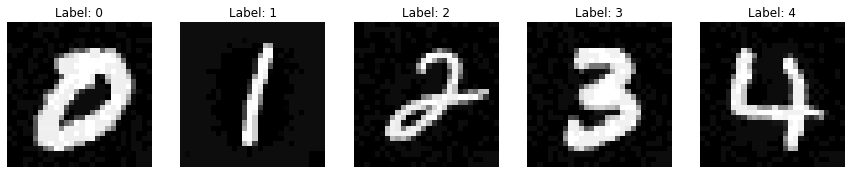

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 选取前 5 个样本进行展示
num_samples = 5
samples_to_show = perturbed_samples[:num_samples]

plt.figure(figsize=(15, 3))
for i, (img, label) in enumerate(samples_to_show):
    plt.subplot(1, num_samples, i + 1)
    # 如果图像是 tensor，先 detach 后转换为 numpy 数组
    if isinstance(img, torch.Tensor):
        img = img.detach()  # 解除梯度追踪
        # 如果是灰度图 (1, H, W)
        if img.shape[0] == 1:
            img_np = img.squeeze(0).cpu().numpy()
            plt.imshow(img_np, cmap='gray')
        else:
            # 颜色图 (C, H, W) -> (H, W, C)
            img_np = img.permute(1, 2, 0).cpu().numpy()
            plt.imshow(img_np)
    else:
        # 如果是 PIL Image，则直接转换为 numpy 数组
        img_np = np.array(img)
        plt.imshow(img_np)
    plt.title(f"Label: {label}")
    plt.axis("off")
plt.show()


In [15]:
# 假设 perturbed_samples 是列表，每个元素为 (img, label)
# 确保 perturbed_samples 中的张量在 CPU 上（如果已经是 CPU，则不需要转换）
# 在生成 perturbed_samples 后，解除梯度追踪并确保在 CPU 上
perturbed_samples = [(img.detach().cpu(), label) for (img, label) in perturbed_samples]

# 构造 Dataset
from torch.utils.data import Dataset, ConcatDataset

class ListDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        return self.samples[idx]

# 合并到客户端数据集（假设 client_subsets[0] 已经是一个 Dataset）
client_subsets[0] = ConcatDataset([client_subsets[0], ListDataset(perturbed_samples)])
print("Client0 新的数据量:", len(client_subsets[0]))

# 构造 DataLoader
from torch.utils.data import DataLoader
client_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in client_subsets]



# 计算每个客户端数据量
client_data_counts = [len(dataset) for dataset in client_subsets]
print("每个客户端数据量:", client_data_counts)

global_model = SimpleNN().to(device)


for r in range(num_rounds):
    print(f"==== 第 {r+1} 轮通信 ====")
    client_state_dicts = []
    local_models = []
    
    # 遍历每个客户端，进行本地训练和测试
    for c_id, client_loader in enumerate(client_loaders):
        local_model = SimpleNN().to(device)
        # 同步全局模型参数到客户端
        local_model.load_state_dict(global_model.state_dict())
        # 客户端本地训练
        local_state = local_train(local_model, client_loader, local_epochs, device)
        client_state_dicts.append(local_state)
        local_models.append(local_model)
        
        # 测试当前客户端本地模型在整个测试集上的表现
        overall_acc, class_acc, backdoor_asr = evaluate_model(local_model, device, test_loader, n_classes)
        print(f"Client {c_id} local model test accuracy: {overall_acc:.2f}%")
        print(f"Backdoor Attack Success Rate (ASR): {backdoor_asr:.2f}%")
        for i in range(n_classes):
            print(f"  Class {i} accuracy: {class_acc[i]:.2f}%")
    
    # 使用数据量加权的 FedAvg 聚合各客户端模型
    global_model = fed_trimean(global_model, client_state_dicts)
    
    # 选择性：测试聚合后的全局模型
    global_acc, global_class_acc, backdoor_asr = evaluate_model(global_model, device, test_loader, n_classes)
    print(f"Global model after round {r+1} test accuracy: {global_acc:.2f}%")
    print(f"Backdoor Attack Success Rate (ASR): {backdoor_asr:.2f}%")
    for i in range(n_classes):
        print(f"  Global model Class {i} accuracy: {global_class_acc[i]:.2f}%")
    print("\n")

Client0 新的数据量: 14665
每个客户端数据量: [14665, 12089, 11263, 12183, 11800]
==== 第 1 轮通信 ====
Client 0 local model test accuracy: 21.12%
Backdoor Attack Success Rate (ASR): 0.00%
  Class 0 accuracy: 99.69%
  Class 1 accuracy: 100.00%
  Class 2 accuracy: 0.00%
  Class 3 accuracy: 0.00%
  Class 4 accuracy: 0.00%
  Class 5 accuracy: 0.00%
  Class 6 accuracy: 0.00%
  Class 7 accuracy: 0.00%
  Class 8 accuracy: 0.00%
  Class 9 accuracy: 0.00%
Client 1 local model test accuracy: 19.85%
Backdoor Attack Success Rate (ASR): 0.00%
  Class 0 accuracy: 0.00%
  Class 1 accuracy: 0.00%
  Class 2 accuracy: 97.87%
  Class 3 accuracy: 96.53%
  Class 4 accuracy: 0.00%
  Class 5 accuracy: 0.00%
  Class 6 accuracy: 0.00%
  Class 7 accuracy: 0.00%
  Class 8 accuracy: 0.00%
  Class 9 accuracy: 0.00%
Client 2 local model test accuracy: 18.53%
Backdoor Attack Success Rate (ASR): 0.00%
  Class 0 accuracy: 0.00%
  Class 1 accuracy: 0.00%
  Class 2 accuracy: 0.00%
  Class 3 accuracy: 0.00%
  Class 4 accuracy: 99.29%
  Cl